In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

In [ ]:
###################
##### SET PARAMETERS
################### 
TICKER="TSLA"
DATA_INTERVAL_MINUTES = 15   # (Set to 5 or 15)
DATA_AFTER_HOURS = False
###################
##### SET PARAMETERS
###################

In [656]:
import sys
sys.path.append('..\\..')

from datetime import datetime

import settings
import apis.tiingo_api as tiingo

secret_key= settings.get_secret("tiingo-key")

### TRAINING DATA
csv_data2019= tiingo.download_ticker(secret_key, TICKER, datetime(2019, 1, 1), datetime(2020,1,1), DATA_INTERVAL_MINUTES, DATA_AFTER_HOURS)
csv_data2020= tiingo.download_ticker(secret_key, TICKER, datetime(2020, 1, 1), datetime(2021,1,1), DATA_INTERVAL_MINUTES, DATA_AFTER_HOURS)
csv_data2021= tiingo.download_ticker(secret_key, TICKER, datetime(2021, 1, 1), datetime(2022,1,1), DATA_INTERVAL_MINUTES, DATA_AFTER_HOURS)
csv_data2022= tiingo.download_ticker(secret_key, TICKER, datetime(2022, 1, 1), datetime(2023,1,1), DATA_INTERVAL_MINUTES, DATA_AFTER_HOURS)
csv_data2023= tiingo.download_ticker(secret_key, TICKER, datetime(2023, 1, 1), datetime(2024,1,1), DATA_INTERVAL_MINUTES, DATA_AFTER_HOURS)
# csv_data2024= tiingo.download_ticker(secret_key, TICKER, datetime(2024, 1, 1), datetime(2024,2,1), DATA_INTERVAL_MINUTES, DATA_AFTER_HOURS)

### TEST PREDICTIONS ON RECENT DATA
# # For first prediction need 2584 ticks = 2584 / 26 ~ 100 days -> 100 * 7 / 5 / 30 = 4.6 months
# csv_data2023= tiingo.download_ticker(secret_key, TICKER, datetime(2023, 8, 1), datetime(2023,12,31), DATA_INTERVAL_MINUTES, DATA_AFTER_HOURS)
# csv_data2024= tiingo.download_ticker(secret_key, TICKER, datetime(2024, 1, 1), datetime(2024,12,31), DATA_INTERVAL_MINUTES, DATA_AFTER_HOURS)


Retrieving TSLA from 2019-01-01 00:00:00 to 2020-01-01 00:00:00 on 15m - https://api.tiingo.com/iex/TSLA/prices?token=REMOVED_SECRET&startDate=2019-01-01&endDate=2020-01-01&resampleFreq=15min&afterHours=false&format=csv
Retrieving TSLA from 2020-01-01 00:00:00 to 2021-01-01 00:00:00 on 15m - https://api.tiingo.com/iex/TSLA/prices?token=REMOVED_SECRET&startDate=2020-01-01&endDate=2021-01-01&resampleFreq=15min&afterHours=false&format=csv
Retrieving TSLA from 2021-01-01 00:00:00 to 2022-01-01 00:00:00 on 15m - https://api.tiingo.com/iex/TSLA/prices?token=REMOVED_SECRET&startDate=2021-01-01&endDate=2022-01-01&resampleFreq=15min&afterHours=false&format=csv
Retrieving TSLA from 2022-01-01 00:00:00 to 2023-01-01 00:00:00 on 15m - https://api.tiingo.com/iex/TSLA/prices?token=REMOVED_SECRET&startDate=2022-01-01&endDate=2023-01-01&resampleFreq=15min&afterHours=false&format=csv
Retrieving TSLA from 2023-01-01 00:00:00 to 2024-01-01 00:00:00 on 15m - https://api.tiingo.com/iex/TSLA/prices?token=RE

In [657]:
import io
import pandas as pd

# ### TRAINING DATA
df2019 = pd.read_csv(io.StringIO(csv_data2019))
df2020 = pd.read_csv(io.StringIO(csv_data2020))
df2021 = pd.read_csv(io.StringIO(csv_data2021))
df2022 = pd.read_csv(io.StringIO(csv_data2022))
df2023 = pd.read_csv(io.StringIO(csv_data2023))
# df2024 = pd.read_csv(io.StringIO(csv_data2024))

if not df2019.empty:
    print("Concatenating from 2019")
    df = pd.concat([df2019, df2020, df2021, df2022, df2023], axis=0, ignore_index=True)
elif not df2020.empty:
    print("Concatenating from 2020")
    df = pd.concat([df2020, df2021, df2022, df2023], axis=0, ignore_index=True)
else:
    print("Concatenating from 2021")
    df = pd.concat([df2021, df2022, df2023], axis=0, ignore_index=True)

# if not df2024.empty:
#     print("Concatenating from 2024")
#     df = pd.concat([df, df2024], axis=0, ignore_index=True)

### TEST PREDICTIONS ON RECENT DATA
# df2023 = pd.read_csv(io.StringIO(csv_data2023))
# df2024 = pd.read_csv(io.StringIO(csv_data2024))
# df = pd.concat([df2023, df2024], axis=0, ignore_index=True)


Concatenating from 2019


In [658]:
# Checks if ordered ascending

# Sort the DataFrame to check if it is in ascending order
df_sorted = df.sort_values("date")

# Check if the sorted DataFrame is equal to the original DataFrame
is_ascending = df_sorted.equals(df)

if is_ascending:
    print("The DataFrame is in ascending order.")
else:
    print("The DataFrame is not in ascending order.")


The DataFrame is in ascending order.


In [659]:
close_list = df['close'].astype(float).tolist()

print(f"df First: {df[:10]}")
print(f"close First: {close_list[:10]}")
print(f"df Last: {df[-10:]}")
print(f"close Last: {close_list[-10:]}")

df First:                         date    close    high      low     open   volume
0  2019-01-02 09:30:00-05:00  301.680  310.58  298.910  306.960  82825.0
1  2019-01-02 09:45:00-05:00  303.945  305.24  300.770  301.770  42264.0
2  2019-01-02 10:00:00-05:00  307.860  309.87  302.600  303.925  35422.0
3  2019-01-02 10:15:00-05:00  304.820  308.30  304.570  308.115  11805.0
4  2019-01-02 10:30:00-05:00  305.390  305.78  303.030  304.240   4504.0
5  2019-01-02 10:45:00-05:00  307.200  307.85  304.960  305.730   4614.0
6  2019-01-02 11:00:00-05:00  307.700  308.28  306.825  307.380  10676.0
7  2019-01-02 11:15:00-05:00  306.660  307.64  305.690  307.640   6901.0
8  2019-01-02 11:30:00-05:00  312.105  312.62  307.095  307.800  17656.0
9  2019-01-02 11:45:00-05:00  308.140  312.29  307.755  312.015   4179.0
close First: [301.68, 303.945, 307.86, 304.82, 305.39, 307.2, 307.7, 306.66, 312.105, 308.14]
df Last:                             date    close     high      low     open   volume
33790 

In [660]:
###################
##### SET PARAMETERS
###################
DAYS_PREDICT = 4
# ISSUE: If stock steadily goes down less than 'DOWN_PCTS_PREDICT' then won't sell but after few periods will be very down 
#  example: DOWN_PCTS_PREDICT=5% then down 4% and down 3% and down 1%... and never sell
# If DOWN_PCTS_PREDICT is too low (ex. 1) is very unlikey it does not go down 1% in 52 periods even if at the end of the day goes up 7%
# Evem "DOWN_PCTS_PREDICT" is written as positive for calculations is down = negative
DOWN_PCTS_PREDICT= [4]
UP_PCTS_PREDICT= [7]
###################
##### SET PARAMETERS
###################

In [661]:

# If quotes every 15min there 26 per day if quotes every 5min there are 78 per day
TICKS_IN_DAY = 26 if DATA_INTERVAL_MINUTES == 15 else 78
# How many data ticks are inspecting to determine the if up or down by percentage 
TICKS_PREDICT= TICKS_IN_DAY * DAYS_PREDICT

import classificators.series_classificator as classificator

classes_calc = classificator.SeriesClassificator(classificator.find_first_down_up, TICKS_PREDICT, DOWN_PCTS_PREDICT, UP_PCTS_PREDICT)

classes= classes_calc.classify(close_list)
print(f"classes: {classes[-TICKS_PREDICT-1:-TICKS_PREDICT+1]}")
price_classes = [(pc[0], pc[1]) for pc in zip(close_list[2650:3000], classes[2650:3000])]
print(f"prices vs classes (window={TICKS_PREDICT}): {price_classes}")


classes: [1, nan]
prices vs classes (window=104): [(195.3, 0), (195.59, 0), (195.81, 0), (196.95, 0), (194.09, 1), (192.68, 1), (191.74, 1), (190.21, 1), (189.365, 1), (190.06, 1), (190.87, 1), (190.39, 1), (191.47, 1), (191.0, 1), (191.23, 1), (190.45, 1), (190.27, 1), (189.47, 1), (189.845, 1), (190.23, 1), (190.74, 1), (190.9, 1), (191.01, 1), (190.66, 1), (190.19, 1), (191.03, 1), (190.865, 1), (190.68, 1), (190.68, 1), (190.68, 1), (190.68, 1), (190.68, 1), (190.68, 1), (190.68, 1), (190.68, 1), (190.68, 1), (190.68, 1), (190.68, 1), (190.68, 1), (190.68, 1), (190.68, 1), (190.68, 1), (190.68, 1), (190.68, 1), (190.68, 1), (190.68, 1), (190.68, 1), (190.68, 1), (190.68, 1), (190.68, 1), (190.68, 1), (190.68, 1), (190.68, 1), (190.68, 1), (194.205, 0), (191.66, 0), (188.57, 1), (188.98, 0), (189.65, 0), (190.22, 0), (189.295, 0), (190.74, 0), (191.6, 0), (190.555, 0), (190.365, 0), (190.24, 0), (189.2, 0), (190.0, 0), (191.02, 0), (190.5, 0), (191.27, 0), (191.05, 0), (190.355, 0),

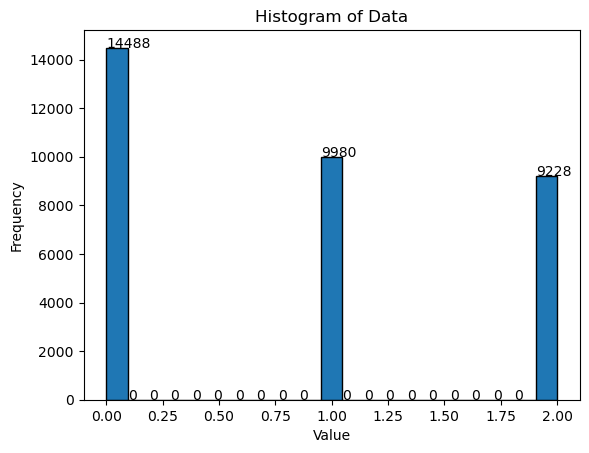

In [662]:
import matplotlib.pyplot as plt

# Create a histogram
hist_values, bin_edges, _ = plt.hist(classes, bins=21, edgecolor='black')

# Add labels and a title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Data')

# Display frequency on top of each bar
for value, edge in zip(hist_values, bin_edges[:-1]):
    plt.text(edge, value, str(int(value)), color='black')
    
# Show the histogram
plt.show()


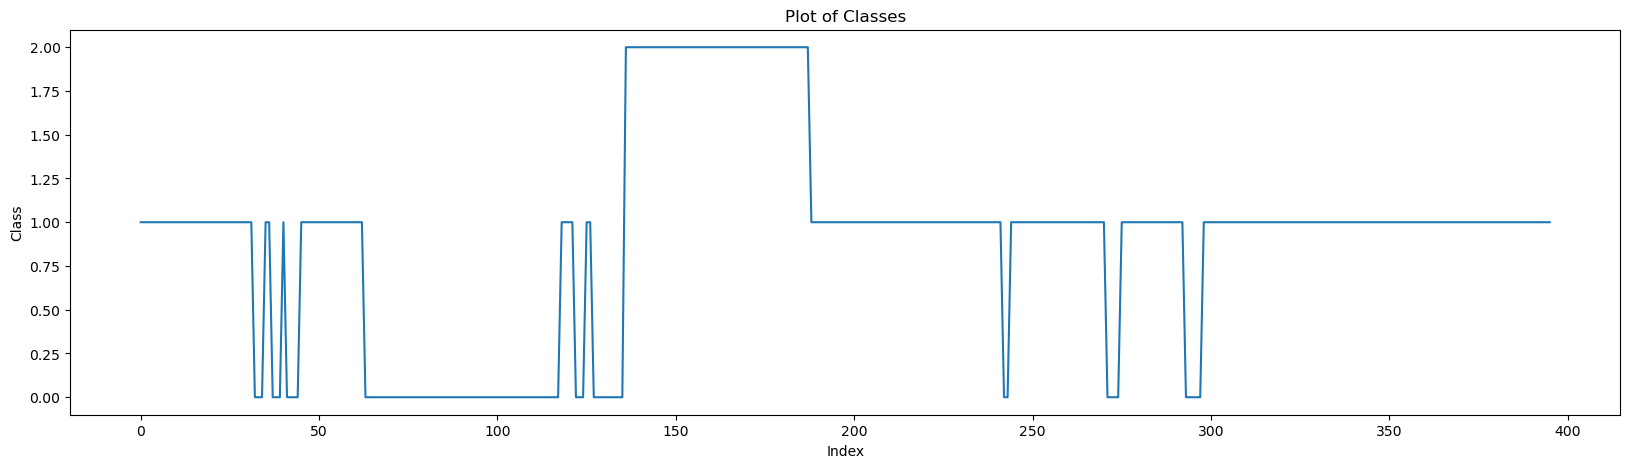

In [663]:
import matplotlib.pyplot as plt

# Generating x-axis values
x = range(len(classes[-500:]))

plt.figure(figsize=(20,5))
plt.plot(x, classes[-500:], linestyle='-')

# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Class')
plt.title('Plot of Classes')

# Showing the plot
plt.show()

In [664]:
import classificators.list_utils as lu


lu.display_frequency_numbers(classes, DOWN_PCTS_PREDICT, UP_PCTS_PREDICT)

Total: 33800
 27.30%   9228 times   7% change (2)
 42.86%  14488 times  -4% change (0)
 29.53%   9980 times   0% change (1)
  0.31%    104 times   0% change (nan)


In [665]:
###################
##### SET PARAMETERS
###################
signal_avg= [
    2, 
    3, 
    5, 
    8, 
    13, 
    21, 
    34, 
    55, 
    89, 
    144, 
    233, 
    377, 
    610, 
    987, 
    1597, 
    2584]
###################
##### SET PARAMETERS
###################

In [666]:

import classificators.proportions_calc as proportions

signals_calculator = proportions.ProportionsCalc(signal_avg)

proportions_avg = signals_calculator.calculate(close_list)


In [667]:
print(f"Prices length: {len(close_list)}")
print(f"Proportions length: {len(proportions_avg[-1])}")

print(f"Last 10 close: {close_list[-10:]}")
print(f"Last 10 proportions(avg={signal_avg[0]}): {proportions_avg[0][-10:]}")

print(f"Proportions avgs: Length: {len(signal_avg)} Last: {signal_avg[-1]}")
# At the end of the data, when less ticks than necessary no possible to predict so "nan" 
print(f"Classes last non-nan: {classes[-TICKS_PREDICT-1:-TICKS_PREDICT+1]} len: {len(classes)}")
print(f"Proportions first non-nan(avg={signal_avg[-1]}): {proportions_avg[-1][signal_avg[-1]-2:signal_avg[-1]]} len: {len(proportions_avg[-1])}")
print(f"Proportions (avg={signal_avg[0]}) Min: {min(proportions_avg[0][signal_avg[0]-1:-TICKS_PREDICT-1])} Max: {max(proportions_avg[0][signal_avg[0]-1:-TICKS_PREDICT])}")
print(f"Proportions (avg={signal_avg[-1]}) Min: {min(proportions_avg[-1][signal_avg[-1]-1:-TICKS_PREDICT-1])} Max: {max(proportions_avg[-1][signal_avg[-1]-1:-TICKS_PREDICT])}")

Prices length: 33800
Proportions length: 33800
Last 10 close: [250.6, 250.715, 249.965, 249.415, 250.09, 250.605, 250.4, 250.4, 249.19, 248.5]
Last 10 proportions(avg=2): [0.001486432561780908, 0.0002293440758721968, -0.0015002100294749534, -0.001102580037358268, 0.0013495141748262583, 0.0010275134174588952, -0.00040934504799400464, -7.071375788794607e-14, -0.002427866286840148, -0.0013883299799505255]
Proportions avgs: Length: 16 Last: 2584
Classes last non-nan: [1, nan] len: 33800
Proportions first non-nan(avg=2584): [nan, -0.3989563404324635] len: 33800
Proportions (avg=2) Min: -1.9502283711002766 Max: 0.07537671689558442
Proportions (avg=2584) Min: -2.487705376731546 Max: 0.6134148294687672


In [668]:
# Cutting the "nan"s: 
#   At the beging first signal_avg[-1] are "nan" (need previous values for first avg.)
#   At the end decided not predict if period to predict is shorter
targets = classes[signal_avg[-1]-1:-TICKS_PREDICT]
inputs = []
for proportion in proportions_avg:
    proportion_cut= proportion[signal_avg[-1]-1:-TICKS_PREDICT]
    print(proportion_cut[:2])
    inputs.append(proportion_cut)

print(f"First target: {targets[0]} and last target: {targets[-1]}")
print(f"Classes: {len(classes)} after cut to targets: {len(targets)}")
print(f"Inputs len: {len(inputs[len(signal_avg)-1])}")
print(f"Distinct targets: {list(set(targets))}")


[-0.001823468532850179, 0.004662630602477096]
[-0.0008049545775629514, 0.005012531328320961]
[0.000980730373074247, 0.007772678449372463]
[0.0061388053816968284, 0.012471316277707777]
[0.003065019353030941, 0.011862197952425409]
[9.739246346764442e-05, 0.009537991546585953]
[0.001919135403408614, 0.01055230704721967]
[-0.020603402314505005, -0.009848558823267527]
[-0.05768013604304566, -0.04632760582325515]
[-0.0883696042032875, -0.07744249015395718]
[-0.11992377854999434, -0.10859697596926905]
[-0.1566280904615039, -0.14540346871173945]
[-0.197081763618046, -0.1853820067520304]
[-0.2579944332754731, -0.24590435350998985]
[-0.309100243307088, -0.2966180668922108]
[-0.3989563404324635, -0.38572769513244454]
First target: 0 and last target: 1
Classes: 33800 after cut to targets: 31113
Inputs len: 31113
Distinct targets: [0, 1, 2]


In [669]:
###################
##### SET PARAMETERS
###################
# SET index_keep TO THE CLASS WANT TO SET AS 1, WANT THE NN TO LEARN - SET THE OTHER INDEX REMOVE 
### Learn when "down"
# index_keep= 0
# index_remove_a= 1
# index_remove_b= 2

### Learn when "up"
index_keep= 2
index_remove_a= 0
index_remove_b= 1
###################
##### SET PARAMETERS
###################

In [670]:
from collections import Counter

print("After removing the nan at the begining and the end")
lu.display_frequency_numbers(targets, DOWN_PCTS_PREDICT, UP_PCTS_PREDICT)

targets_frequency = Counter(targets)
print("VALIDATE removing should be POSITIVE?")
count_remove_a= targets_frequency[index_remove_a] - targets_frequency[index_keep] + targets_frequency[index_keep] //2
count_remove_b= targets_frequency[index_remove_b] - targets_frequency[index_keep] + targets_frequency[index_keep] //2
print(f"Removing {index_remove_a}: {count_remove_a}")
print(f"Removing {index_remove_b}: {count_remove_b}")


After removing the nan at the begining and the end
Total: 31113
 42.36%  13178 times  -4% change (0)
 28.83%   8971 times   0% change (1)
 28.81%   8964 times   7% change (2)
VALIDATE removing should be POSITIVE?
Removing 0: 8696
Removing 1: 4489


In [671]:
###################
##### SET PARAMETERS
###################
# DECISION SET: REMOVING?
indexes_remove_a= []
# 2024-03-01 Do not remove anything
# if count_remove_a > 0:
#     indexes_remove_a = get_indexes_value(targets, index_remove_a, count_remove_a)

# DECISION SET: REMOVING?
indexes_remove_b= []
# 2024-03-01 Do not remove anything
# if count_remove_b > 0:
#     indexes_remove_b = get_indexes_value(targets, index_remove_b, count_remove_b)

indexes_remove= indexes_remove_a + indexes_remove_b
targets_clean= lu.remove_indexes(targets, indexes_remove)

lu.display_frequency_numbers(targets_clean, DOWN_PCTS_PREDICT, UP_PCTS_PREDICT)
print(f"Targets len: {len(targets)} Targets clean: {len(targets_clean)} Difference: {len(targets)-len(targets_clean)}")

inputs_clean = [lu.remove_indexes(input, indexes_remove) for input in inputs]    
print(f"targets_clean positions(Keep={index_keep})(First:{targets_clean.index(index_keep)},Last:-{targets_clean[::-1].index(index_keep)})")


Total: 31113
 42.36%  13178 times  -4% change (0)
 28.83%   8971 times   0% change (1)
 28.81%   8964 times   7% change (2)
Targets len: 31113 Targets clean: 31113 Difference: 0
targets_clean positions(Keep=2)(First:225,Last:-208)


In [672]:
# Sets 'index_keep' as target = 1 and rest of indexes to target=0
targets_binary= lu.convert_binary(targets_clean, index_keep)
print(f"targets_binary First {targets_binary.index(True)} and Last(counting from end) {targets_binary[::-1].index(True)} position with True")
print(f"targets_binary len: {len(targets_binary)} Input clean[0]: {len(inputs_clean[0])} Input clean[-1]: {len(inputs_clean[-1])}")

targets_binary First 225 and Last(counting from end) 208 position with True
targets_binary len: 31113 Input clean[0]: 31113 Input clean[-1]: 31113


In [675]:
import torch

inputs_tensor = torch.Tensor(inputs_clean)
print(f"inputs_tensor: {inputs_tensor.size()}")
inputs_tensor = inputs_tensor.T
print(f"inputs_tensor: {inputs_tensor.size()}")
targets_tensor = torch.Tensor(targets_binary)
print(f"inputs_clean len0 x len1: {len(inputs_clean)} x {len(inputs_clean[0])} -> inputs_tensor.shape: {inputs_tensor.shape}")
print(f"targets_binary.shape: {len(targets_binary)} -> targets_tensor.shape: {targets_tensor.shape}")
print(f"inputs_tensor: {inputs_tensor}")
print(f"targets_tensor: {targets_tensor}")

inputs_tensor: torch.Size([16, 31113])
inputs_tensor: torch.Size([31113, 16])
inputs_clean len0 x len1: 16 x 31113 -> inputs_tensor.shape: torch.Size([31113, 16])
targets_binary.shape: 31113 -> targets_tensor.shape: torch.Size([31113])
inputs_tensor: tensor([[-1.8235e-03, -8.0495e-04,  9.8073e-04,  ..., -2.5799e-01,
         -3.0910e-01, -3.9896e-01],
        [ 4.6626e-03,  5.0125e-03,  7.7727e-03,  ..., -2.4590e-01,
         -2.9662e-01, -3.8573e-01],
        [-3.6644e-04,  2.6221e-03,  4.5341e-03,  ..., -2.4646e-01,
         -2.9728e-01, -3.8656e-01],
        ...,
        [-7.0894e-14, -4.1524e-14,  4.5012e-15,  ...,  6.1169e-02,
          6.2858e-02,  4.5298e-02],
        [-7.0894e-14, -4.1524e-14,  4.5012e-15,  ...,  6.0981e-02,
          6.2854e-02,  4.5293e-02],
        [-7.0894e-14, -4.1524e-14,  4.5012e-15,  ...,  6.0832e-02,
          6.2844e-02,  4.5288e-02]])
targets_tensor: tensor([0., 0., 0.,  ..., 0., 0., 0.])


In [676]:
#Shuffle tensors
torch.manual_seed(42) 
permutation = torch.randperm(inputs_tensor.size(0))
inputs_tensor_shuffle = inputs_tensor[permutation]

targets_tensor_shuffle = targets_tensor[permutation]

print(f"inputs_tensor.size(0): {inputs_tensor.size(0)}")
print(f"inputs_tensor.shape: {inputs_tensor.shape} -> inputs_tensor_shuffle.shape: {inputs_tensor_shuffle.shape}")
print(f"targets_tensor.shape: {targets_tensor.shape} -> targets_tensor_shuffle.shape: {targets_tensor_shuffle.shape}")

inputs_tensor.size(0): 31113
inputs_tensor.shape: torch.Size([31113, 16]) -> inputs_tensor_shuffle.shape: torch.Size([31113, 16])
targets_tensor.shape: torch.Size([31113]) -> targets_tensor_shuffle.shape: torch.Size([31113])


In [677]:
###################
##### SET PARAMETERS
###################
### If training
TRAIN_SPLIT = 0.8
#### If real data
# TRAIN_SPLIT = 1
###################
##### SET PARAMETERS
###################

In [678]:

train_test_split= int(TRAIN_SPLIT * len(targets_tensor))
inputs_tensor_train, targets_tensor_train= inputs_tensor_shuffle[:train_test_split], targets_tensor_shuffle[:train_test_split]
inputs_tensor_test, targets_tensor_test= inputs_tensor_shuffle[train_test_split:], targets_tensor_shuffle[train_test_split:]

print(f"inputs_tensor_train: {inputs_tensor_train.size(0)} inputs_tensor_test: {inputs_tensor_test.size(0)}")

inputs_tensor_train: 24890 inputs_tensor_test: 6223


In [679]:
#All values represented after split
print(f"Distinct targets_tensor_train: {list(set(targets_tensor_train.tolist()))}")
print(f"Distinct targets_tensor_test: {list(set(targets_tensor_test.tolist()))}")

Distinct targets_tensor_train: [0.0, 1.0]
Distinct targets_tensor_test: [0.0, 1.0]


In [680]:
from typing import Tuple
import torch
from torch.utils.data import Dataset

class StockDataset(Dataset):
    def __init__(
        self,
        inputs,
        targets):
        
        self.inputs= inputs
        self.targets= targets

    def __len__(self) -> int:
        return len(self.targets)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        return self.inputs[index], self.targets[index]


In [681]:
from torch.utils.data import DataLoader

# TODO: When executing only using 33-38% GPU - Try different BATCH_SIZE see if parallelism increases? Learning decreases because less batches?
BATCH_SIZE= 32

train_dataset= StockDataset(
  inputs_tensor_train,
  targets_tensor_train
)

print(f"train_dataset: {train_dataset[0]}")

train_dataloader= DataLoader(
  dataset=train_dataset,
  batch_size=BATCH_SIZE,
  shuffle=False
)

train_input0, train_target0= next(iter(train_dataloader))
print(f"train_input0: {train_input0} train_target0: {train_target0}")


train_dataset: (tensor([0.0029, 0.0029, 0.0037, 0.0110, 0.0206, 0.0269, 0.0338, 0.0397, 0.0473,
        0.0574, 0.0639, 0.0810, 0.0766, 0.0528, 0.0488, 0.0701]), tensor(0.))
train_input0: tensor([[ 2.9412e-03,  2.8589e-03,  3.7063e-03,  1.1032e-02,  2.0598e-02,
          2.6880e-02,  3.3756e-02,  3.9671e-02,  4.7299e-02,  5.7439e-02,
          6.3908e-02,  8.1022e-02,  7.6582e-02,  5.2754e-02,  4.8788e-02,
          7.0129e-02],
        [-2.4536e-03, -3.0305e-03, -3.9793e-03, -3.8590e-03, -6.7475e-04,
          4.6924e-03,  2.2498e-02,  3.3410e-02,  3.6265e-02,  3.7667e-02,
          6.4866e-02,  1.2690e-01,  1.8400e-01,  2.0849e-01,  1.8752e-01,
          1.4342e-01],
        [-1.1268e-03, -2.0693e-03, -1.6413e-03,  5.2088e-04,  1.8120e-03,
          9.6066e-03,  2.5070e-02,  4.4512e-02,  6.8096e-02,  6.7778e-02,
          7.0663e-02,  9.2760e-02,  5.6314e-02,  6.4036e-03, -2.6330e-02,
         -5.8500e-02],
        [-1.4042e-03, -3.4924e-03, -6.5076e-03, -8.2238e-03, -1.0844e-02,
   


### STOP HERE WHEN TESTING WITH REAL DATA: 
Go to step that load saved network

In [682]:
test_dataset= StockDataset(
  inputs_tensor_test,
  targets_tensor_test
)

print(f"train_dataset: {train_dataset[0]}")

test_dataloader= DataLoader(
  dataset=test_dataset,
  batch_size=BATCH_SIZE,
  shuffle=False
)

test_input0, test_target0= next(iter(test_dataloader))
print(f"test_input0: {train_input0} test_target0: {test_target0}")


train_dataset: (tensor([0.0029, 0.0029, 0.0037, 0.0110, 0.0206, 0.0269, 0.0338, 0.0397, 0.0473,
        0.0574, 0.0639, 0.0810, 0.0766, 0.0528, 0.0488, 0.0701]), tensor(0.))
test_input0: tensor([[ 2.9412e-03,  2.8589e-03,  3.7063e-03,  1.1032e-02,  2.0598e-02,
          2.6880e-02,  3.3756e-02,  3.9671e-02,  4.7299e-02,  5.7439e-02,
          6.3908e-02,  8.1022e-02,  7.6582e-02,  5.2754e-02,  4.8788e-02,
          7.0129e-02],
        [-2.4536e-03, -3.0305e-03, -3.9793e-03, -3.8590e-03, -6.7475e-04,
          4.6924e-03,  2.2498e-02,  3.3410e-02,  3.6265e-02,  3.7667e-02,
          6.4866e-02,  1.2690e-01,  1.8400e-01,  2.0849e-01,  1.8752e-01,
          1.4342e-01],
        [-1.1268e-03, -2.0693e-03, -1.6413e-03,  5.2088e-04,  1.8120e-03,
          9.6066e-03,  2.5070e-02,  4.4512e-02,  6.8096e-02,  6.7778e-02,
          7.0663e-02,  9.2760e-02,  5.6314e-02,  6.4036e-03, -2.6330e-02,
         -5.8500e-02],
        [-1.4042e-03, -3.4924e-03, -6.5076e-03, -8.2238e-03, -1.0844e-02,
    

In [683]:
###################
##### SET PARAMETERS
###################
HIDDEN_UNITS=12
###################
##### SET PARAMETERS
###################

In [684]:
# EXECUTE FROM THIS STEP To CREATE A NETWORK WITH RANDOM WEIGHTS

import torch
from torch import nn

class StockModelBinaryV0(nn.Module):
  def __init__(self, input_features, hidden_units):
    """Initializes multi-class classification model"""
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
      nn.Linear(in_features=input_features, out_features=hidden_units*16),
      nn.LeakyReLU(negative_slope=0.1),
      nn.Linear(in_features=hidden_units*16, out_features=hidden_units*8),
      nn.LeakyReLU(negative_slope=0.1),
      nn.Linear(in_features=hidden_units*8, out_features=hidden_units*4),
      nn.LeakyReLU(negative_slope=0.1),
      nn.Linear(in_features=hidden_units*4, out_features=hidden_units),
      nn.LeakyReLU(negative_slope=0.1),
      nn.Linear(in_features=hidden_units, out_features=1)
    )

  def forward(self, x):
    # print("forward x: ",", ".join([str(num) for num in x.tolist()]))
    # Layers are defined inside the Sequencial NN and will be applied here.
    return self.linear_layer_stack(x)

# Create an instance of the model
model_0 = StockModelBinaryV0(
  input_features=len(signal_avg),
  hidden_units=HIDDEN_UNITS).to(device)


In [685]:
import torchmetrics

# loss_fn = nn.BCEWithLogitsLoss()

# Loss function for an imbalanced dataset (there many more 0's than 1's). Apply more weight to the less frequent class
num_ones = torch.count_nonzero(targets_tensor_train)
num_samples = [len(targets_tensor_train)-num_ones, num_ones]
class_weights = 1.0 / torch.tensor(num_samples, dtype=torch.float32)
class_weights = class_weights / torch.sum(class_weights)
print(f"num_ones: {num_ones} class_weights: {class_weights}")

loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])

best_test_performance = 0
best_model_state_dict = None


num_ones: 7123 class_weights: tensor([0.2862, 0.7138])


In [686]:
###################
##### SET PARAMETERS
###################
# PERFORMANCE_MEASURE="accu"
# performance_fn= torchmetrics.Accuracy(task='binary').to(device)
PERFORMANCE_MEASURE="prec"
performance_fn= torchmetrics.Precision(task='binary').to(device)
# PERFORMANCE_MEASURE="reca"
# performance_fn= torchmetrics.Recall(task='binary').to(device)
###################
##### SET PARAMETERS
###################

In [713]:
###################
##### SET PARAMETERS
###################
# DO: AFTER THIS CELL RUNS EXECUTE CELLS UNTIL SAVE STEP TO KEEP BEST RESULT IN CASE IT GOES DOWN
#    lr = 0.1 -> 0.03 -> 0.001
#    epochs 200 + 200 (lr=0.1) -> 100 (lr=0.03) -> 100 (lr=0.001)
# EXECUTE 0.1 x 200 for 2 TIMES (or 400 for 1 time)
# optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)
# epochs=400
# optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.03)
# epochs=100
# optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.005)
# epochs=100
# optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.0007)
# epochs=100
# optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.0001)
# epochs=100
###Using Adam optimizer
# learning_rate = 0.005
# beta_1 = 0.9
# beta_2 = 0.999
# decay = 0.01
# optimizer = optim.Adam(params=model_0.parameters(), lr=learning_rate, betas=(beta_1, beta_2), eps=1e-8, weight_decay=decay)
# epochs=2000
##### Using a StepLR Scheduler
from torch.optim.lr_scheduler import StepLR

# rate= 0.01
# gamma = 0.45
# optimizer = torch.optim.SGD(params=model_0.parameters(), lr=rate)
# scheduler = StepLR(optimizer, step_size=100, gamma=gamma)
# epochs=900
## If continue optimization
last_rate= 0.0000586
gamma = 0.95
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=last_rate*gamma)
scheduler = StepLR(optimizer, step_size=20, gamma=gamma)
epochs= 200
###################
##### SET PARAMETERS
###################

In [714]:
for epoch in range(epochs):
    train_loss, train_performance= 0, 0
    train_samples = 0

    # Training
    model_0.train()

    for batch, (X, y) in enumerate(train_dataloader):
        X= X.to(device)
        y= y.to(device)

        # Forward pass
        y_logits= model_0(X).squeeze()
        
        # turn logits -> prediction probabilities -> prediction labels
        y_pred= torch.round(torch.sigmoid(y_logits))
        
        # Calculate loss and accuracy
        loss= loss_fn(y_logits, y)
        train_loss+= loss * X.size(0)
        train_performance+= performance_fn(y_pred, y) * X.size(0)
        train_samples += X.size(0)
        
        # Zero the gradients to avoid accomulating gradients from previous iteration
        optimizer.zero_grad()
        
        # Backpropagation
        loss.backward()
        
        # Updates the model usign the gradients
        optimizer.step()
    
    train_loss /= train_samples
    train_performance /= train_samples
      
    model_0.eval()
    test_loss, test_performance= 0, 0
    test_samples = 0
    with torch.inference_mode():
        for X, y in test_dataloader:
            X= X.to(device)
            y= y.to(device)
        
            # Predict for test data
            test_logits= model_0(X).squeeze()
            test_pred= torch.round(torch.sigmoid(test_logits))
            
            # Calculate test loss/accuracy
            test_loss+= loss_fn(test_logits, y) * X.size(0)
            test_performance+= performance_fn(test_pred, y) * X.size(0)
            test_samples += X.size(0)

        test_loss /= test_samples
        test_performance /= test_samples
    
    if test_performance > best_test_performance:
        best_test_performance = test_performance
        best_model_state_dict = model_0.state_dict().copy()
            
    if epoch % 10 == 0:
      print(f"Epoch: {epoch+1} lr: {optimizer.param_groups[0]['lr']:.7f} | Loss: {train_loss:.5f} {PERFORMANCE_MEASURE}: {train_performance*100:.4f}% | Test loss: {test_loss:.5f} Test {PERFORMANCE_MEASURE}: {test_performance*100:.4f}%")

    # Update the learning rate
    scheduler.step()

print(f"Last Loss: {train_loss:.5f} {PERFORMANCE_MEASURE}: {train_performance*100:.4f}% | Test loss: {test_loss:.5f} Test {PERFORMANCE_MEASURE}: {test_performance*100:.4f}%")

Epoch: 1 lr: 0.0000557 | Loss: 0.19712 prec: 91.0513% | Test loss: 0.21539 Test prec: 90.4401%
Epoch: 11 lr: 0.0000557 | Loss: 0.19677 prec: 91.0954% | Test loss: 0.21505 Test prec: 90.3887%
Epoch: 21 lr: 0.0000529 | Loss: 0.19634 prec: 91.1899% | Test loss: 0.21462 Test prec: 90.6154%
Epoch: 31 lr: 0.0000529 | Loss: 0.19602 prec: 91.2024% | Test loss: 0.21429 Test prec: 90.6705%
Epoch: 41 lr: 0.0000502 | Loss: 0.19561 prec: 91.1990% | Test loss: 0.21389 Test prec: 90.8462%
Epoch: 51 lr: 0.0000502 | Loss: 0.19530 prec: 91.1619% | Test loss: 0.21357 Test prec: 90.8462%
Epoch: 61 lr: 0.0000477 | Loss: 0.19491 prec: 91.2510% | Test loss: 0.21320 Test prec: 91.0205%
Epoch: 71 lr: 0.0000477 | Loss: 0.19462 prec: 91.2651% | Test loss: 0.21290 Test prec: 91.0391%
Epoch: 81 lr: 0.0000453 | Loss: 0.19426 prec: 91.3717% | Test loss: 0.21254 Test prec: 90.9009%
Epoch: 91 lr: 0.0000453 | Loss: 0.19398 prec: 91.3977% | Test loss: 0.21225 Test prec: 90.9009%
Epoch: 101 lr: 0.0000431 | Loss: 0.19364 

After training results: Test loss: 0.20963 Test prec: 91.07%
Confusion matrix:
tensor([[4245,  137],
        [ 444, 1397]])
false_positives: 137 true_positives: 1397


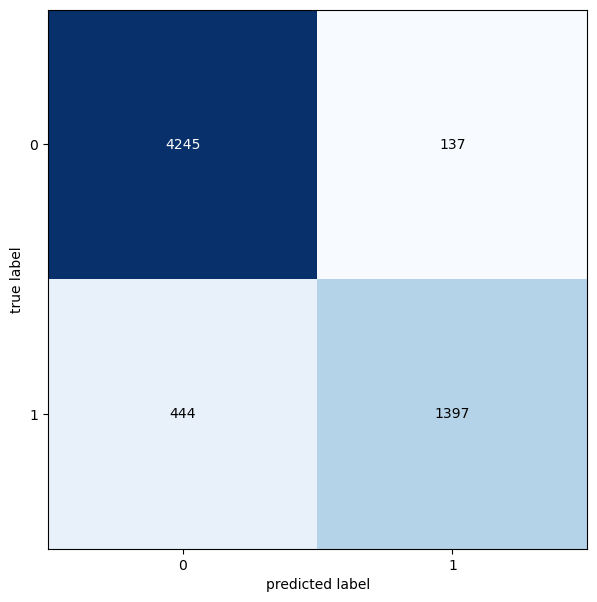

In [717]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

model_0.eval()
test_loss, test_performance= 0, 0
with torch.inference_mode():
    X= inputs_tensor_test.to(device)
    y= targets_tensor_test.to(device)

    # Predict for test data
    test_logits= model_0(X).squeeze()
    test_pred= torch.round(torch.sigmoid(test_logits))
    
    # Calculate test loss/accuracy
    test_loss+= loss_fn(test_logits, y)
    test_performance+= performance_fn(test_pred, y)

    # test_loss /= targets_tensor_test.size(0)
    # test_performance /= targets_tensor_test.size(0)

print(f"After training results: Test loss: {test_loss:.5f} Test {PERFORMANCE_MEASURE}: {test_performance*100:.2f}%")

confmat= ConfusionMatrix(task='binary')

# test_data.targets are the values we want to predict in the test dataloader
confmat_tensor= confmat(
  preds= test_pred.cpu(),
  target= targets_tensor_test.cpu())

# Plot the confusion matrix
fig, ax= plot_confusion_matrix(
  conf_mat= confmat_tensor.numpy(),
  figsize= (10, 7)
)

print(f"Confusion matrix:\n{confmat_tensor}")

false_positives = confmat_tensor[0, 1].item()
true_positives = confmat_tensor[1, 1].item()
print(f"false_positives: {false_positives} true_positives: {true_positives}")

In [716]:
# DECISION SET: MODEL_NAME = Name of the file where saving model results

from pathlib import Path
from datetime import date

# Create directory, if it doesn't exist, to store models
MODEL_PATH= Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

target= "UP" if len(DOWN_PCTS_PREDICT) > 0 else "DOWN"

# Create path to the model
MODEL_NAME= f"{date.today().strftime('%Y-%m-%d')}-{TICKER}-predict{target}-dates20190101-20240101-in16-hid{HIDDEN_UNITS}-down{DOWN_PCTS_PREDICT[0]}-up{UP_PCTS_PREDICT[0]}-{PERFORMANCE_MEASURE}{test_performance*10000:.0f}pct-fp{false_positives}tp{true_positives}-imbalance"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(
  obj=model_0.state_dict(),
  f=f"{MODEL_SAVE_PATH}.pth")

torch.save(
    obj=best_model_state_dict, 
    f=f"{MODEL_SAVE_PATH}-model-best.pth")


print(f"Model saved as: {MODEL_NAME}")

Model saved as: 2024-04-29-TSLA-predictUP-dates20190101-20240101-in16-hid12-down4-up7-prec9107pct-fp137tp1397-imbalance


### Steps for saved network

In [ ]:
# Loads the save network
from pathlib import Path

# Create directory, if it doesn't exist, to store models
MODEL_PATH= Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME= f"2024-04-29-TSLA-predictUP-dates20190101-20240201-in16-hid12-down2-up4-loss9255pct-prec-fp82tp1019-imbalance.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

loaded_model_0 = StockModelBinaryV0(16, 12)
# Created a model from same class and since load_state_dict() is method from nn.Module it can be called to populate the state
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
loaded_model_0.to(device)

In [ ]:
# Execute with saved network

loaded_model_0.eval()
real_loss, real_performance= 0, 0
with torch.inference_mode():
    X= inputs_tensor_train.to(device)
    y= targets_tensor_train.to(device)

    # Predict for test data
    real_logits= loaded_model_0(X).squeeze()
    real_pred= torch.round(torch.sigmoid(real_logits))
    
    # Calculate test loss/accuracy
    real_loss+= loss_fn(real_logits, y)
    real_performance+= performance_fn(real_pred, y)    

    real_loss /= targets_tensor_train.size(0)
    real_performance /= targets_tensor_train.size(0)

print(f"File model eval: Real loss: {real_loss:.5f} Real {PERFORMANCE_MEASURE}: {real_performance*100:.2f}%")

confmat_real= ConfusionMatrix(task='binary')

# test_data.targets are the values we want to predict in the test dataloader
confmat_real_tensor= confmat(
  preds= real_pred.cpu(),
  target= targets_tensor_train.cpu())

print(f"Confusion matrix:\n{confmat_real_tensor}")

In [ ]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary  


In [ ]:
summary(model_0, input_size=[len(signal_avg)])